# Entrenamiento modelo para detección de Phising a partir de una URL

Importamos la librerías necesarias para la realización del proyecto

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Ejemplo pySparkSQL") \
    .config("spark.sql.warehouse.dir", "file:///D:/tmp/spark-warehouse") \
    .getOrCreate()

sc = spark.sparkContext

25/12/23 20:14:33 WARN Utils: Your hostname, MacBook-Pro-de-Sergio.local resolves to a loopback address: 127.0.0.1; using 10.253.85.48 instead (on interface en0)
25/12/23 20:14:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/23 20:14:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%matplotlib inline 
from pyspark.sql import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql.types import NumericType

from pyspark.ml import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *

Guardamos el path del csv

In [3]:
csv_path = "/Users/vergara/Documents/Master/Computación Avanzada/Practicas_BigData/URL_phising_detector/phishing_features.csv"

Cargamos el csv en un dataframe e imprimimos el schema del mismo

In [4]:
df = spark.read.csv(csv_path, inferSchema=True, header=True)
print("Elementos en DataFrame a partir de datos/personas.csv: " + str(df.count()) + "\nEsquema: ")
print (df.printSchema())
type(df)

Elementos en DataFrame a partir de datos/personas.csv: 160064
Esquema: 
root
 |-- url: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- num_dots: integer (nullable = true)
 |-- has_https: integer (nullable = true)
 |-- has_ip: integer (nullable = true)
 |-- num_subdirs: integer (nullable = true)
 |-- num_params: integer (nullable = true)
 |-- suspicious_words: integer (nullable = true)
 |-- tld: string (nullable = true)
 |-- special_char_count: integer (nullable = true)
 |-- digits_count: integer (nullable = true)
 |-- entropy: double (nullable = true)

None


pyspark.sql.dataframe.DataFrame

Lo primero que vamos a comprobar es si nuestro dataset está desbalanceado o no. Al tener un problema binario, lo ideal sería tener un 50% de ejemplos de cada clase. En el caso de que la diferencia sea muy obvia, tendremos que aplicar ciertas medidas para que no afecte al rendimiento del modelo

In [5]:
count_1 = df.filter(df['label'] == 1).count()
count_0 = df.filter(df['label'] == 0).count()
total = df.count()


perc_0 = (count_0 / total) * 100
perc_1 = (count_1 / total) * 100

print()

print(f"Benign (0): {count_0} records ({perc_0:.2f}%)")
print(f"Phishing (1): {count_1} records ({perc_1:.2f}%)")


Benign (0): 820 records (0.51%)
Phishing (1): 159244 records (99.49%)


Comprobamos que en efecto, nuestro dataset está desbalanceado

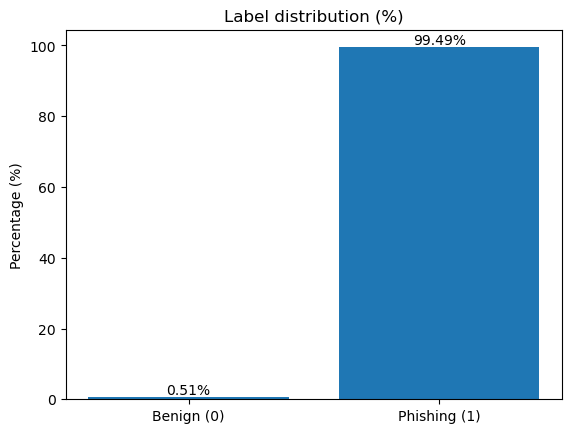

In [6]:
labels = ["Benign (0)", "Phishing (1)"]
percentages = [perc_0, perc_1]

plt.figure()
bars = plt.bar(labels, percentages)
plt.ylabel("Percentage (%)")
plt.title("Label distribution (%)")

# Añadir el texto del porcentaje encima de cada barra
for bar, perc in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{perc:.2f}%",
        ha="center",
        va="bottom"
    )

plt.show()

A continuación, vamos a buscar si nuestro dataset posee valores nulos. Muchos modelos no aceptan valores nulos en su entrenamiento. Si no los tratamos, probablemente nos salte un error y no podremos continuar hasta que lo solucionemos. Si, por lo que sea, el modelo acepta los valores nulos, estos pueden suponer un problema que afecta al rendimiento del modelo ya que perderemos información que puede ser valiosa en el entrenamiento o podemos caer en sesgos. Buscamos valores nulos en el dataset para tratarlo de forma adecuada.

In [8]:
condition = reduce(
    lambda a, b: a | b,
    [col(c).isNull() for c in df.columns]
)

n = df.filter(condition).count()
df.filter(condition).show(n, truncate=False)

+------------------------+-----+----------+--------+---------+------+-----------+----------+----------------+----+------------------+------------+------------------+
|url                     |label|url_length|num_dots|has_https|has_ip|num_subdirs|num_params|suspicious_words|tld |special_char_count|digits_count|entropy           |
+------------------------+-----+----------+--------+---------+------+-----------+----------+----------------+----+------------------+------------+------------------+
|https://verify-att.app./|1    |24        |2       |1        |0     |3          |0         |1               |NULL|1                 |0           |3.688721875540867 |
|google.com              |0    |10        |1       |0        |0     |0          |0         |0               |NULL|0                 |0           |2.6464393446710157|
|youtube.com             |0    |11        |1       |0        |0     |0          |0         |0               |NULL|0                 |0           |3.095795255000934 |
|wik

Vemos que hay varios registros cuyo tld (dominio) es nulo. Vamos a recorrer todas las url cuyo tld sea nulo y vamos a asignarles su 

In [9]:
df = df.withColumn(
    "tld",
    when(col("tld").isNull(),    
        element_at(split(lit(col("url")), r"\."), -1).alias("tld")
    ).otherwise(col("tld"))
)

df = df.cache()
df.count()

df.filter((col("url") == 'google.com') | (col('url') == 'wikipedia.org') | (col('url') == 'safeexample99.net')).show(truncate=False)




+-----------------+-----+----------+--------+---------+------+-----------+----------+----------------+---+------------------+------------+------------------+
|url              |label|url_length|num_dots|has_https|has_ip|num_subdirs|num_params|suspicious_words|tld|special_char_count|digits_count|entropy           |
+-----------------+-----+----------+--------+---------+------+-----------+----------+----------------+---+------------------+------------+------------------+
|google.com       |0    |10        |1       |0        |0     |0          |0         |0               |com|0                 |0           |2.6464393446710157|
|wikipedia.org    |0    |13        |1       |0        |0     |0          |0         |0               |org|0                 |0           |3.334679141051595 |
|safeexample99.net|0    |17        |1       |0        |0     |0          |0         |0               |net|0                 |2           |3.381580488309163 |
+-----------------+-----+----------+--------+-------

Vemos en tres de URL antes filtradas que ya no tienen tld nulo

### Atención: es importante darle un valor numérico a cada dominio (los modelos no aceptan strings)

In [10]:
# todo: transformar todos los strings del dataset a valor numérico

## Implementación de Modelos

Dividimos nuestros datos en train y test

In [32]:
seed = 12418
train, test_total = df.randomSplit([0.8, 0.2], seed=seed)

train.cache()
test_total.cache()

train_count = train.count() 
test_count_total = test_total.count()

print(f"Train count: {train_count}")
print(f"Test count: {test_count_total}")

Train count: 128146
Test count: 31918


25/12/23 20:45:09 WARN CacheManager: Asked to cache already cached data.
25/12/23 20:45:09 WARN CacheManager: Asked to cache already cached data.


In [33]:
val, test = df.randomSplit([0.5, 0.5], seed=seed)

val.cache()
test.cache()

val_count = val.count()
test_count = test.count()

print(f"Validation count: {val_count}")
print(f"Test count: {test_count}")


Validation count: 80284
Test count: 79780


25/12/23 20:45:11 WARN CacheManager: Asked to cache already cached data.
25/12/23 20:45:11 WARN CacheManager: Asked to cache already cached data.


In [ ]:
feature_cols = ['url_length', 'num_dots', 'has_https', 'has_ip', 'num_subdirs', 'num_params', 'suspicious_words', 'special_char_count', 'digits_count', 'entropy']

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

train_1 = assembler.transform(train)
test_1 = assembler.transform(val)

logistic_regression = LogisticRegression(maxIter = 20, regParam = 0.01, featuresCol = 'features', labelCol = 'label')

model = logistic_regression.fit(train_1)
prediction = model.transform(test_1)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

evaluator.evaluate(prediction)


0.9922416129990254

In [23]:
cm_df = prediction.groupBy("label", "prediction").count()

cm_df.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|79367|
|    0|       1.0|  413|
+-----+----------+-----+



Aplicamos medidas para que este desbalance no nos afecte en exceso

In [ ]:
# Todo: MEDIDAS PARA TRATAR DESBALANCEO DE CLASES